In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2 as transforms
from PIL import Image

# Generate Dataset and Dataloader

In [2]:
# variables definitions
DATASET_DIR = "/media/luchocode/Extra vol/ExoNet_Images/ExoNet_Images"
LABELS_FILE = "/home/luchocode/Downloads/Labels.csv"
IMAGE_PATH_FORMAT = "{}/{}/['{}'] frame {}.jpg"

In [6]:
labels = pd.read_csv(LABELS_FILE)
labels["exist"] = labels.apply(lambda row: os.path.exists(
    IMAGE_PATH_FORMAT.format(
        DATASET_DIR,
        row[2],
        row[0],
        row[1])
    ), axis=1)
labels = labels[labels["exist"] == True].reset_index(drop=True)
labels.info()

/tmp/ipykernel_7360/319004266.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[2],
/tmp/ipykernel_7360/319004266.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[0],
/tmp/ipykernel_7360/319004266.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[1])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922782 entries, 0 to 922781
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   video   922782 non-null  object
 1   frame   922782 non-null  int64 
 2   class   922782 non-null  object
 3   exist   922782 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 22.0+ MB


In [7]:
min_frames = labels.groupby(['video'])['frame'].count().min()
min_frames

# Function to upsample frames for each video
def upsample_video(df, min_frames):
    splits = len(df) // min_frames
    rest_frames = len(df) % min_frames
    add_frames = min_frames - rest_frames
    
    if splits == 1 and add_frames == 0:
        return df
    
    balanced_df = None
    for i in range(splits):
        _df = df.iloc[i*min_frames:(i+1)*min_frames]
        _df["video_chunk"] = _df["video"] + f"_part{i}"
        if balanced_df is None:
            balanced_df = _df
        else:
            balanced_df = pd.concat([balanced_df, _df], axis=0)

    if add_frames:
        _df = balanced_df.iloc[-min_frames:]
        _df["video"] = _df["video"] + f"_part{splits}"
        balanced_df = pd.concat([balanced_df, _df], axis=0)
    
    return balanced_df

# Apply upsampling to each video group
labels_balanced = labels.groupby('video', group_keys=False).apply(lambda x: upsample_video(x, min_frames))
labels_balanced = labels_balanced.reset_index(drop=True)
# Now all videos have the same number of frames
labels_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985000 entries, 0 to 984999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   video        985000 non-null  object
 1   frame        985000 non-null  int64 
 2   class        985000 non-null  object
 3   exist        985000 non-null  bool  
 4   video_chunk  985000 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 31.0+ MB


/tmp/ipykernel_7360/462692215.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  labels_balanced = labels.groupby('video', group_keys=False).apply(lambda x: upsample_video(x, min_frames))


In [8]:
import os
from torch.utils.data import Dataset

class ExoNetDataset(Dataset):
    def __init__(
        self,
        df_labels: pd.DataFrame,
        seq_len: int,
        img_dir: str,
        transform=None,
        target_transform=None
    ):
        self.img_labels = df_labels
        self.seq_len = seq_len
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)//self.seq_len

    def __getitem__(self, idx):
        """
        Return an image and its label
        """
        start_seq_idx = idx * self.seq_len
        end_seq_idx = (idx+1) * self.seq_len
        file_name_format = "['{}'] frame {}.jpg"
        frames = [
            Image.open(
                os.path.join(
                    self.img_dir,
                    self.img_labels.iloc[i, 2],
                    file_name_format.format(
                        self.img_labels.iloc[i, 0],
                        self.img_labels.iloc[i, 1]
                    )
                )
            ) for i in range(start_seq_idx, end_seq_idx)
        ]
        labels = [self.img_labels.iloc[i, 2] for i in range(start_seq_idx, end_seq_idx)]        
        
        if self.transform:
            frames = self.transform(frames)
        if self.target_transform:
            labels = self.target_transform(labels)

        frames_tensor = torch.stack(frames)
        labels_tensor = torch.from_numpy(labels)

        return frames_tensor, labels_tensor


In [9]:
# Transforms
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
MEAN_DATASET = [0.485, 0.456, 0.406]
STD_DATASET = [0.229, 0.224, 0.225]

unique_labels = labels['class'].unique()
print(f"Unique labels: {len(unique_labels)}")

encoder = LabelEncoder()
encoder.fit(unique_labels)

image_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=MEAN_DATASET,
        std=STD_DATASET
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
])


Unique labels: 12


In [10]:
dataset = ExoNetDataset(
    df_labels=labels_balanced,
    img_dir=DATASET_DIR,
    seq_len=min_frames,
    target_transform=encoder.transform,
    transform=image_transform
)
print(f"Total video chunks of {min_frames} frames: {len(dataset)}")
frames_tensor, labels_tensor = dataset[0]
print(f"Frames shape: {frames_tensor.shape}. Labels shape: {labels_tensor.shape}")

Total video chunks of 1970 frames: 500
Frames shape: torch.Size([1970, 3, 256, 256]). Labels shape: torch.Size([1970])


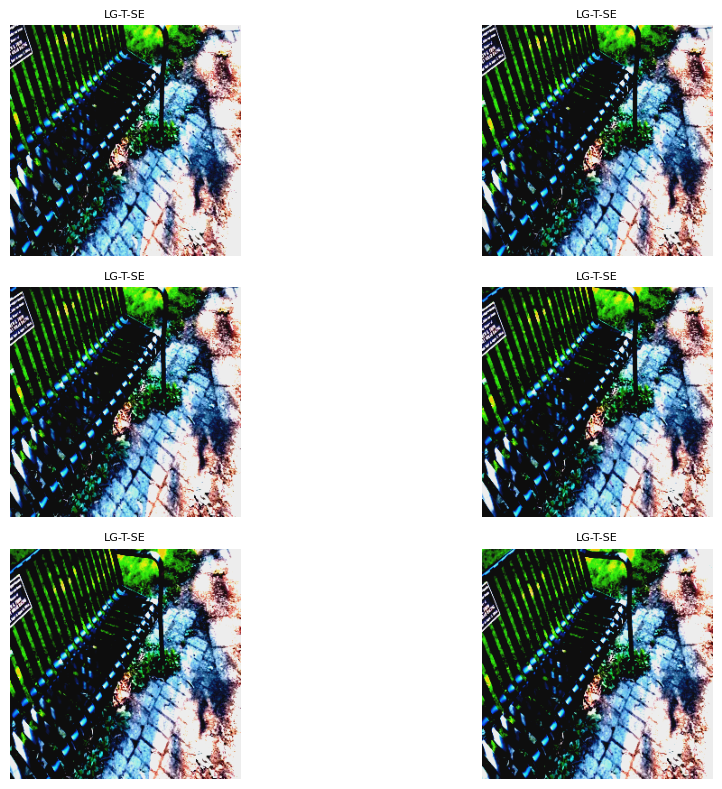

In [11]:
# Visualize image
import math

def show_images_in_grid(
    tensor_images,
    labels_images,
    cols=3,
    figsize=(12, 8)
):
    """
    Display images in a grid layout.

    Args:
        tensor_images (tensor): A tensor object.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.
    """
    n_images = len(tensor_images)
    rows = math.ceil(n_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for ax, img_tensor, label in zip(axes, tensor_images, labels_images):
        try:
            img = img_tensor.clone()
            img = img.permute(1,2,0)
            img = img.numpy()
            ax.imshow(img)
            ax.set_title(label, fontsize=8)
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, f"Error\n{e}", ha="center", va="center")
            ax.axis("off")

    # Hide empty subplots if any
    for ax in axes[n_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_images_in_grid(
    tensor_images=frames_tensor[100:106,],
    labels_images=encoder.inverse_transform(labels_tensor[100:106,]),
    cols=2
)

In [ ]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [12]:
class CustomConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size=3):
        super().__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        padding = kernel_size // 2
        # One weight matrix for all gates
        self.conv = nn.Conv2d(
            in_channels=input_channels + hidden_channels,
            out_channels=4 * hidden_channels,
            kernel_size=kernel_size,
            padding=padding
        )

    def forward(self, x_t, h_prev, c_prev):
        """
        Args:
            x_t: (batch_size, input_size)
            h_prev: (batch_size, hidden_size)
            c_prev: (batch_size, hidden_size)
        """
        combined = torch.cat([x_t, h_prev], dim=1) # (batch_size, input_channels + hidden_channels)
        gates = self.conv(combined) # (batch_size, 4 * hidden_channel)

        f_t, i_t, o_t, c__t = torch.chunk(gates, 4, dim=1)

        f_t = torch.sigmoid(f_t) # forget gate
        i_t = torch.sigmoid(i_t) # input gate
        o_t = torch.sigmoid(o_t) # output gate
        c__t = torch.tanh(c__t) # candidate cell state

        c_t = f_t * c_prev + i_t * c__t # new cell state
        h_t = o_t * torch.tanh(c_t) # new hidden state

        return h_t, c_t


In [54]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm_cell = CustomLSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, input_size)
        """
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            x_t = x[:, t, :] # (batch_size, input_size)
            h_t, c_t = self.lstm_cell(x_t, h_t, c_t)
        
        # Use last hidden state for output
        out = self.fc(h_t) # (batch_size, output_size)
        return out